In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

data_path = "./../data/"

In [ ]:
#Run to segment regular black and white CAPTCHAs
def segment_captcha():
    for image_name in os.listdir(data_path):
        img_path = data_path + image_name
        img = cv2.imread(img_path)
        _, thresholded = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY_INV)
        to_gray = cv2.cvtColor(thresholded, cv2.COLOR_BGR2GRAY)
        ctrs, _ = cv2.findContours(to_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        ctrs = np.asarray(ctrs, dtype=object)
        my_rects = np.asarray([cv2.boundingRect(ctr) for ctr in ctrs])

        while len(my_rects) != 4:
            big_ctr_ind = np.argmax(my_rects[:, 2])
            big_ctr = my_rects[big_ctr_ind]
            split_width = big_ctr[2]//2
            sub_rect_one = np.asarray([big_ctr[0], big_ctr[1], split_width, 0])
            sub_rect_two = np.asarray([big_ctr[0] + split_width, big_ctr[1], big_ctr[2] - split_width, 0])
            my_rects = np.concatenate((my_rects[:big_ctr_ind], np.asarray([sub_rect_one, sub_rect_two]), my_rects[big_ctr_ind + 1:]))
        
        assert(len(my_rects) == 4)
        my_rects = np.sort(my_rects, axis=0)
        code = image_name.split(".")[0]
        for i, rect in enumerate(my_rects):
            new_image = to_gray[:,rect[0]-1:rect[0]+rect[2]+1] #Add one pixel of noise from original image
            total_pad = 24 - new_image.shape[1]
            left_pad  = total_pad // 2
            right_pad = total_pad - left_pad
            new_image = np.pad(new_image, pad_width=((0,0), (left_pad, right_pad)), mode="constant")
            cv2.imwrite("../processed_data/" + code + "_" + str(i) + "_" + code[i] + ".png", new_image)

segment_captcha()


In [ ]:
#Train test split
processed_data_path = "./../processed_data/"
def get_data(test_split, processed_data_path):
    images = []
    labels = []
    captcha = []
    captcha_labels = []
    count = 0
    for image_path in sorted(os.listdir(processed_data_path)):
        count += 1
        image = cv2.imread(processed_data_path + image_path, cv2.IMREAD_GRAYSCALE)
        
        label = image_path.split('.')[0][-1]
        captcha.append(image)
        captcha_labels.append(label)

        if count % 4 == 0:
            images.append(captcha)
            labels.append(captcha_labels) 
            captcha = []
            captcha_labels = []

    X_train, X_testval, Y_train, Y_testval = train_test_split(np.asarray(images, dtype=object), np.asarray(labels, dtype=object), test_size=test_split)
    X_test, X_val, Y_test, Y_val = train_test_split(X_testval, Y_testval, test_size=0.5)
    return X_train, X_test, X_val, Y_train, Y_test, Y_val

X_train, X_test, X_val, Y_train, Y_test, Y_val = get_data(0.3, "./../processed_data/")
print(Y_val)

In [2]:
#Barcode the CAPTCHAs
def binary_captcha():
    for image_name in os.listdir(data_path):
        img_path = data_path + image_name
        img = cv2.imread(img_path)
        _, thresholded = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY_INV)
        to_gray = cv2.cvtColor(thresholded, cv2.COLOR_BGR2GRAY)
        
        code = image_name.split(".")[0]
        for i, letter in enumerate(code):
            new_img = to_gray
            if i > 0:
                new_img = np.concatenate((np.ones((new_img.shape[0], i))*255, new_img), axis=1)
                
            new_img = np.concatenate((np.zeros((new_img.shape[0], 1)), new_img), axis=1)
            if i < 3:
                new_img = np.concatenate((np.ones((new_img.shape[0], 3-i))*255, new_img), axis=1)
            cv2.imwrite("../barcoded_data/" + code + "_" + str(i) + "_" + letter + ".png", new_img)


binary_captcha()

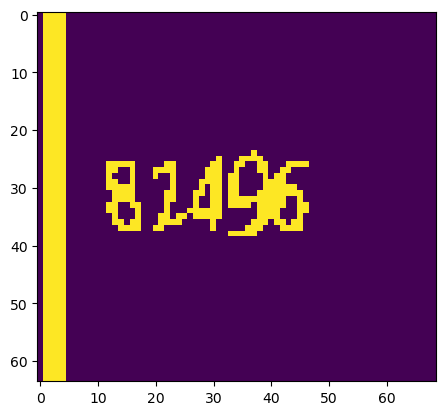

In [38]:
#Barcode the CAPTCHAs

data_difficult_path = "./../data_difficult/"
def binary_captcha():
    for image_name in [os.listdir(data_difficult_path)[10]]:
    #for i in range(1):
        img_path = data_difficult_path + image_name
        img = cv2.imread(img_path)
        _, thresholded = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY_INV)
        to_gray = cv2.cvtColor(thresholded, cv2.COLOR_BGR2GRAY)
        kernel = np.ones((5,5), np.uint8)

        # Apply erosion
        eroded = cv2.erode(to_gray, kernel, iterations=1)

        # Apply dilation
        dilated = cv2.dilate(eroded, kernel, iterations=1)

        #Scale down .5 in size (for space)
        height, width = img.shape[:2]
        new_height = int(height * .25)
        new_width = int(width * .25)
        resized_img = cv2.resize(dilated, (new_width, new_height), interpolation=cv2.INTER_AREA)
        _, new_image = cv2.threshold(resized_img, 240, 255, cv2.THRESH_BINARY)
        
        code = image_name.split(".")[0]
        for i, letter in enumerate(code):
            new_img = new_image
            if i > 0: #Put white space before letter we are denoting
                new_img = np.concatenate((np.ones((new_img.shape[0], i))*255, new_img), axis=1)
                
            #Put black to indicate the letter we are looking for
            new_img = np.concatenate((np.zeros((new_img.shape[0], 1)), new_img), axis=1)

            if i < 4: #Put white space after letter we are denoting
                new_img = np.concatenate((np.ones((new_img.shape[0], 4-i))*255, new_img), axis=1)
            plt.imshow(new_img)
            cv2.imwrite("../barcoded_data_difficult/" + code + "_" + str(i) + "_" + letter + ".png", new_img)


binary_captcha()